# 4.0 Loading data Using Pytorch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
!ls -al ../input/

total 5069940
drwxrwxrwx 1 bhj623 bhj623        512 Apr 19 11:15 .
drwxrwxrwx 1 bhj623 bhj623        512 Apr 19 11:15 ..
-rwxrwxrwx 1 bhj623 bhj623       4830 Mar  6  2020 class_map.csv
-rwxrwxrwx 1 bhj623 bhj623       4865 Mar  6  2020 class_map_corrected.csv
-rwxrwxrwx 1 bhj623 bhj623    7978245 Apr 18 22:54 df_folds.csv
-rwxrwxrwx 1 bhj623 bhj623        944 Mar  6  2020 sample_submission.csv
-rwxrwxrwx 1 bhj623 bhj623       1742 Mar  6  2020 test.csv
-rwxrwxrwx 1 bhj623 bhj623    9903859 Mar  6  2020 test_image_data_0.parquet
-rwxrwxrwx 1 bhj623 bhj623   10003997 Mar  6  2020 test_image_data_1.parquet
-rwxrwxrwx 1 bhj623 bhj623    9996850 Mar  6  2020 test_image_data_2.parquet
-rwxrwxrwx 1 bhj623 bhj623    9995989 Mar  6  2020 test_image_data_3.parquet
-rwxrwxrwx 1 bhj623 bhj623    6281787 Mar  6  2020 train.csv
-rwxrwxrwx 1 bhj623 bhj623 1285682162 Mar  6  2020 train_image_data_0.parquet
-rwxrwxrwx 1 bhj623 bhj623 1278647926 Mar  6  2020 train_image_data_1.parquet
-rwxrwxrwx 1 bhj6

In [6]:
import torch
torch.cuda.is_available()

False

In [3]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import os
import gc
import pandas as pd
import seaborn as sns
import joblib 
from tqdm import tqdm
import warnings
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#(!pip install iterative-stratification)

import torch
from torch.utils.data import Dataset

In [4]:
rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [5]:
# We bring one sample image and pre-process it. And then we could apply the same to entire images

In [6]:
# YOUR PATH
path = f'/mnt/c/Users/bokhy/Desktop/Python/github/kaggle/bengaliai-cv19/input/'

In [7]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

In [8]:
df_train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


## Image Precessing Steps

In [9]:
# 1. Get index
# 2. Call the saved image pickle file for each index
# 3. Reshape the image pickle file for image-processing
# 4. Add the channel for Pytorch usages
# 5. Grab the target value for each label for each image

In [10]:
index = 0
HEIGHT = 137
WIDTH = 236

In [11]:
# let's make an image id
img_ids = df_train['image_id'].values

img_id = img_ids[index]; img_id

# Now we can see that image id is created for index = 0

'Train_0'

In [12]:
# Load the pickle file
# astype(np.unit8) for less memory allocation
img = joblib.load(os.path.join(path, f'train_images/{img_id}.pkl')).astype(np.uint8)

In [13]:
# Take a look at the reshaped image
img.reshape(HEIGHT, WIDTH)

array([[254, 253, 252, ..., 254, 253, 251],
       [255, 253, 253, ..., 254, 253, 252],
       [255, 255, 255, ..., 254, 254, 253],
       ...,
       [254, 254, 253, ..., 253, 254, 252],
       [254, 254, 254, ..., 253, 253, 252],
       [254, 254, 254, ..., 253, 253, 251]], dtype=uint8)

In [14]:
# And save it
img = img.reshape(HEIGHT, WIDTH)

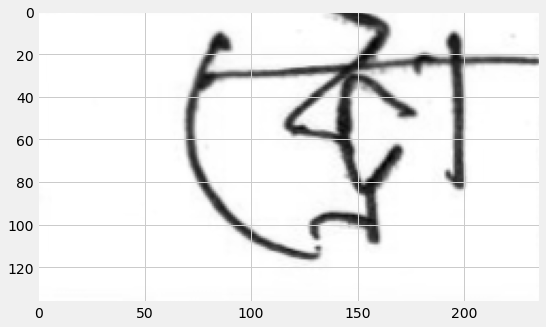

In [15]:
# make it look like MNIST (change black and white) 
img = 255 - img

plt.imshow(255 - img, cmap = 'gray')

In [16]:
# Create a 'Channel' varialbe to put the image in Pytorch (Pytorch requires 3 inputs: Channel, Height, Width)

In [17]:
# Use 'np.newaxis'
img[:, : , np.newaxis].shape

(137, 236, 1)

In [18]:
img = img[:, : , np.newaxis]

In [21]:
# Grab class for each label in each image

In [39]:
label_1 = df_train.iloc[index].grapheme_root
label_2 = df_train.iloc[index].vowel_diacritic
label_3 = df_train.iloc[index].consonant_diacritic

In [40]:
label_1

15

In [41]:
label_2

9

In [42]:
label_3

5

# 5.0 Create a Pytorch Dataset Class

In [43]:
class BengaliDataset(Dataset):
    
    # I define the csv file and the height and width of the image
    def __init__(self, csv, img_height, img_width):
        # To make sure having ordered index with the 'fold'
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
    
    # The lenght of the whole data --> In our case, the lengh of the train CSV file
    def __len__(self):
        return len(self.csv)
    
    # How are we going to process the image and get the final output image --> 'Image Precessing Steps' above
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(os.path.join(path, f'train_images/{img_id}.pkl'))
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:, : , np.newaxis]
        
        label_1 = self.csv.iloc[index].grapheme_root
        lable_2 = self.csv.iloc[index].vowel_diacritic
        lable_3 = self.csv.iloc[index].consonant_diacritic
        
        # Fianl output should be able to be read in Pytorch --> (Batch, Channel, Height, Width)
        return (torch.tensor(img, dtype = torch.float).permute(2,0,1), 
               torch.tensor(label_1, dtype = torch.long),
               torch.tensor(label_2, dtype = torch.long),
               torch.tensor(label_3, dtype = torch.long))

In [44]:
# Explanation on Pytoch image object

# Normally the images are (Batch, Height, Width, Channel) (ex. 16,137,236,1)
# And Pytorch requires the format of (Batch, Channelm, Height, Width) (ex. 16,1,137,236)
# So we use 'permute' tensor object

# For classification target variables, set 'dtype = torch.long'

# 6.0 Make Training & Validation dataset

In [45]:
# Call the 6-fold dataset and add it to the train_set
df_train['fold'] = pd.read_csv(os.path.join(path, 'df_folds.csv'))['fold']

In [46]:
df_train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,fold
0,Train_0,15,9,5,ক্ট্রো,1
1,Train_1,159,0,0,হ,4
2,Train_2,22,3,5,খ্রী,1
3,Train_3,53,2,2,র্টি,2
4,Train_4,71,9,5,থ্রো,0


In [47]:
# Get first 5 fold for training data
trn_fold = [i for i in range(6) if i not in [5]]
trn_fold

[0, 1, 2, 3, 4]

In [48]:
# last fold for validation data
vld_fold = [5]

In [49]:
# Pull the index
trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index

vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [50]:
trn_idx

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            200827, 200829, 200830, 200831, 200832, 200833, 200834, 200835,
            200836, 200839],
           dtype='int64', length=167366)

In [51]:
vld_idx

Int64Index([    10,     17,     31,     35,     45,     46,     50,     51,
                56,     60,
            ...
            200798, 200800, 200804, 200810, 200824, 200825, 200826, 200828,
            200837, 200838],
           dtype='int64', length=33474)

In [52]:
trn_dataset = BengaliDataset(csv = df_train.loc[trn_idx], # put in training CSV file
                            img_height = HEIGHT,
                            img_width = WIDTH)

In [53]:
# Examine the first image in torch
trn_dataset[0][0].shape

torch.Size([1, 137, 236])